In [8]:
import sys
sys.path.append("../..")

import numpy as np
from scipy.special import erf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import *
import matplotlib.pylab as pylab
from cycler import cycler
import palettable

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# from sympy import *

# rho_dm = Symbol('\\rho_\mathrm{dm}')
# omega_l = Symbol('\Omega_l')
# M_0 = Symbol('M_0')
# R_0 = Symbol('R_0')
# D_l = Symbol('D_l')
# D_l_min = Symbol('D_l^\mathrm{min}')
# D_l_max = Symbol('D_l^\mathrm{max}')
# beta_0 = R_0 / D_l
# G_N = Symbol('G_\mathrm{N}')
# v = Symbol('v')
# ell = Symbol('\ell')

# Vol = integrate(4 * pi * D_l **2, (D_l, D_l_min, D_l_max))

# N_lens = omega_l * rho_dm * Vol / M_0

# C_ell = (4 * G_N * M_0 * v / D_l ** 2) ** 2 * (pi / 2) * exp(-ell ** 2 * beta_0 ** 2)

# C_ell_gaussian_pop = simplify(N_lens * integrate(4 * pi * D_l **2 * C_ell, (D_l, D_l_min, D_l_max)) / Vol)

# C_ell_gaussian_pop

In [10]:
# TODO: rewrite these properly and put in spec_calc.py!

def cl_gauss(M0, R0, v, Omega_l, l, Dl):
    return (1.130124740726684e-99*M0**2*v**2*np.exp(-((l**2*R0**2)/Dl**2)))/Dl**4

def cl_pop_gauss(M0, R0, v, Omega_l, l, Dlmin, Dlmax):
    return (-3.868196132832839e-116*M0*v**2*Omega_l*(erf((l*R0)/Dlmax) - erf((l*R0)/Dlmin)))/(l*R0)

def cl_pop_ps(M0, v, Omega_l, Dlmin, Dlmax):
    return 4.36479*10 ** -116 *(-(1/Dlmax) + 1/Dlmin)*M0*v**2*Omega_l

def cl_pop_ps_alpha(M0, v, Omega_l, l, Dlmin, Dlmax):
    return 4.341738820694676e-118*(-Dlmax**(-3) + Dlmin**(-3))*l**2*M0*v**4*Omega_l

def cl_pop_gauss_alpha(M0, R0, v, Omega_l, l, Dlmin, Dlmax):
    return 5.114990543587503e-118*l**2*M0*v**4*Omega_l*(((Dlmax**2/(l**2*R0**2))**1.5*(np.sqrt(np.pi) + 2/(Dlmax*np.exp((l**2*R0**2)/Dlmax**2)*np.sqrt(1/(l**2*R0**2))) - np.sqrt(np.pi)*erf(1/(Dlmax*np.sqrt(1/(l**2*R0**2))))))/Dlmax**3 - ((Dlmin**2/(l**2*R0**2))**1.5*(np.sqrt(np.pi) + 2/(Dlmin*np.exp((l**2*R0**2)/Dlmin**2)*np.sqrt(1/(l**2*R0**2))) - np.sqrt(np.pi)*erf(1/(Dlmin*np.sqrt(1/(l**2*R0**2))))))/Dlmin**3)

In [11]:
def F_single(M_0, R_0, v, Omega_l, l, D_l, sigma_mu, N_q):
    Cl = cl_gauss(M_0, R_0, v, Omega_l, l, D_l) / (asctorad / Year) **2 *1e12
    Nl = 4 * np.pi * sigma_mu ** 2 / N_q
    return (l + 0.5) * (Cl / (Cl + Nl)) ** 2


def F(M_0, R_0, v, Omega_l, l, D_min, D_max, sigma_mu, N_q):
    Cl = cl_pop_gauss(M_0, R_0, v, Omega_l, l, D_min, D_max) / (asctorad / Year) **2 *1e12
    Nl = 4 * np.pi * sigma_mu ** 2 / N_q
    return (l + 0.5) * (Cl / (Cl + Nl)) ** 2

def F_alpha(M_0, R_0, v, Omega_l, l, D_min, D_max, sigma_mu, N_q):
    Cl = cl_pop_gauss_alpha(M_0, R_0, v, Omega_l, l, D_min, D_max) / (asctorad / Year**2) **2 *1e12
    Nl = 4 * np.pi * sigma_mu ** 2 / N_q
    return (l + 0.5) * (Cl / (Cl + Nl)) ** 2


def F_ps(M_0, v, Omega_l, l, D_min, D_max, sigma_mu, N_q):
    Cl = np.array([cl_pop_ps(M_0, v, Omega_l, D_min, D_max) / (asctorad / Year) **2 *1e12]*len(l_ary))
    Nl = 4 * np.pi * sigma_mu ** 2 / N_q
    return (l + 0.5) * (Cl / (Cl + Nl)) ** 2

def F_ps_alpha(M_0, v, Omega_l, l, D_min, D_max, sigma_mu, N_q):
    Cl = cl_pop_ps_alpha(M_0, v, Omega_l, l, D_min, D_max) / (asctorad / Year**2) **2 *1e12
    Nl = 4 * np.pi * sigma_mu ** 2 / N_q
    return (l + 0.5) * (Cl / (Cl + Nl)) ** 2

In [12]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

In [13]:
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/draft/plots/"

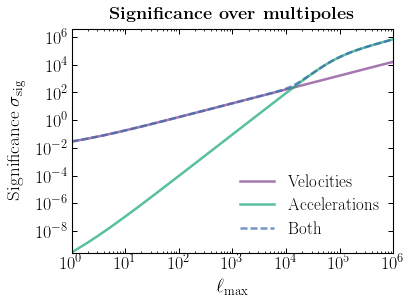

In [10]:
l_ary = np.arange(1,1e6)

sigma_mu = 100
sigma_alpha = 10
Dl_min = .1 * kpc
Dl_max = 10 * kpc
M_0 = 1e8 * M_s

plt.plot(l_ary, np.sqrt(np.cumsum(F_ps(M_0, 1e-3, 1, l_ary, Dl_min, Dl_max, sigma_mu, 1e8))), label=r'Velocities')
plt.plot(l_ary, np.sqrt(np.cumsum(F_ps_alpha(M_0, 1e-3, 1, l_ary, Dl_min, Dl_max, sigma_alpha, 1e11))), label=r'Accelerations')
plt.plot(l_ary, np.sqrt(np.cumsum(F_ps(M_0, 1e-3, 1, l_ary, Dl_min, Dl_max, sigma_mu, 1e8) + F_ps_alpha(M_0, 1e-3, 1, l_ary, Dl_min, Dl_max, sigma_alpha, 1e11))), ls='--', label=r'Both')

plt.xscale("log")
plt.yscale("log")

plt.xlabel("$\ell_\mathrm{max}$")
plt.ylabel('Significance $\sigma_\mathrm{sig}$')

plt.xlim(min(l_ary), max(l_ary))

plt.title(r"\textbf{Significance over multipoles}")

plt.legend(loc='lower right')

plt.tight_layout()

plt.savefig(plots_dir + "mualpha_compact.pdf")

/Users/smsharma/.conda/envs/Lensing-PowerSpectra/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/Users/smsharma/.conda/envs/Lensing-PowerSpectra/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()


3.82935717557e-09


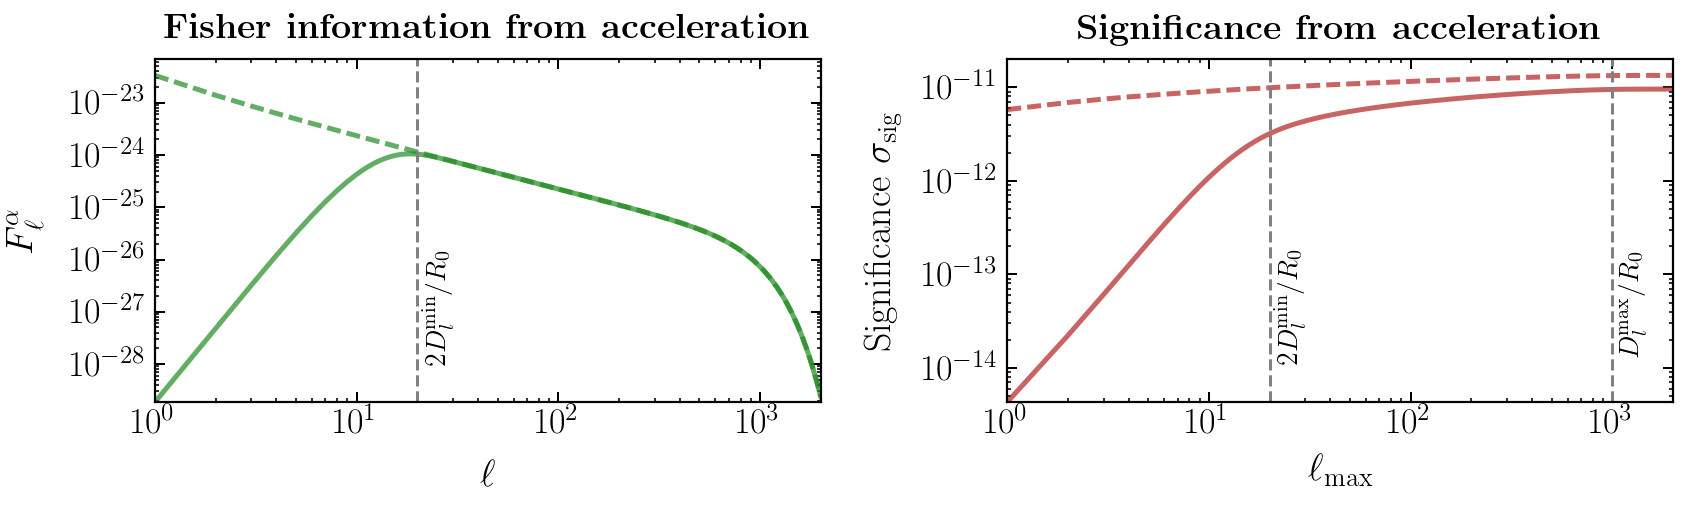

In [21]:
l_ary = np.arange(1,2000)

sigma_alpha = 5
Dl_min = .1 * kpc
Dl_max = 10 * kpc
R_0 = 10 * pc

print(np.sqrt(np.sum(F_alpha(1e8 * M_s, R_0,  1e-3, 1, l_ary, Dl_min, Dl_max, sigma_alpha, 1e8))))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13/1.1,4/1.1))

ax1.plot(l_ary, F_alpha(1e8 * M_s, R_0,  1e-3, 1, l_ary, Dl_min, Dl_max, sigma_mu, 1e8), color='forestgreen')
ax1.plot(l_ary, F_alpha(1e8 * M_s, R_0,  1e-3, 1, l_ary, 1e-12 * kpc, Dl_max, sigma_mu, 1e8), color='forestgreen',ls='--')
ax1.axvline(2 * Dl_min / R_0, ls='--', color='grey', lw=1.5)
ax1.text(10** (np.log10(2 * Dl_min / R_0) + .05 ), 1e-13 * 5e-14, '$2 D_l^\mathrm{min}/R_0$',rotation=90, fontsize=14)

ax1.set_xlabel('$\ell$')
ax1.set_ylabel(r'$F_\ell^{\alpha}$')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title(r"\textbf{Fisher information from acceleration}")

ax1.set_xlim(min(l_ary), max(l_ary))

ax2.plot(l_ary, np.sqrt(np.cumsum(F_alpha(1e8 * M_s, R_0,  1e-3, 1, l_ary, Dl_min, Dl_max, sigma_mu, 1e8))), color='firebrick')
ax2.plot(l_ary, np.sqrt(np.cumsum(F_alpha(1e8 * M_s, R_0,  1e-3, 1, l_ary, 1e-12 * kpc, Dl_max, sigma_mu, 1e8))), color='firebrick',ls='--')
ax2.axvline(Dl_max / R_0, ls='--', color='grey', lw=1.5)
ax2.text(10** (np.log10(Dl_max / R_0) + .05 ), 1e-13, '$D_l^\mathrm{max}/R_0$',rotation=90, fontsize=14)
ax2.axvline(2 * Dl_min / R_0, ls='--', color='grey', lw=1.5)
ax2.text(10** (np.log10(2 * Dl_min / R_0) + .05 ), 1e-13, '$2 D_l^\mathrm{min}/R_0$',rotation=90, fontsize=14)

ax2.set_xlabel('$\ell_\mathrm{max}$')
ax2.set_ylabel('Significance $\sigma_\mathrm{sig}$')

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title(r"\textbf{Significance from acceleration}")
ax2.set_xlim(min(l_ary), max(l_ary))

plt.tight_layout()

plt.savefig(plots_dir + "fisher_alpha.pdf")

1.56737065592


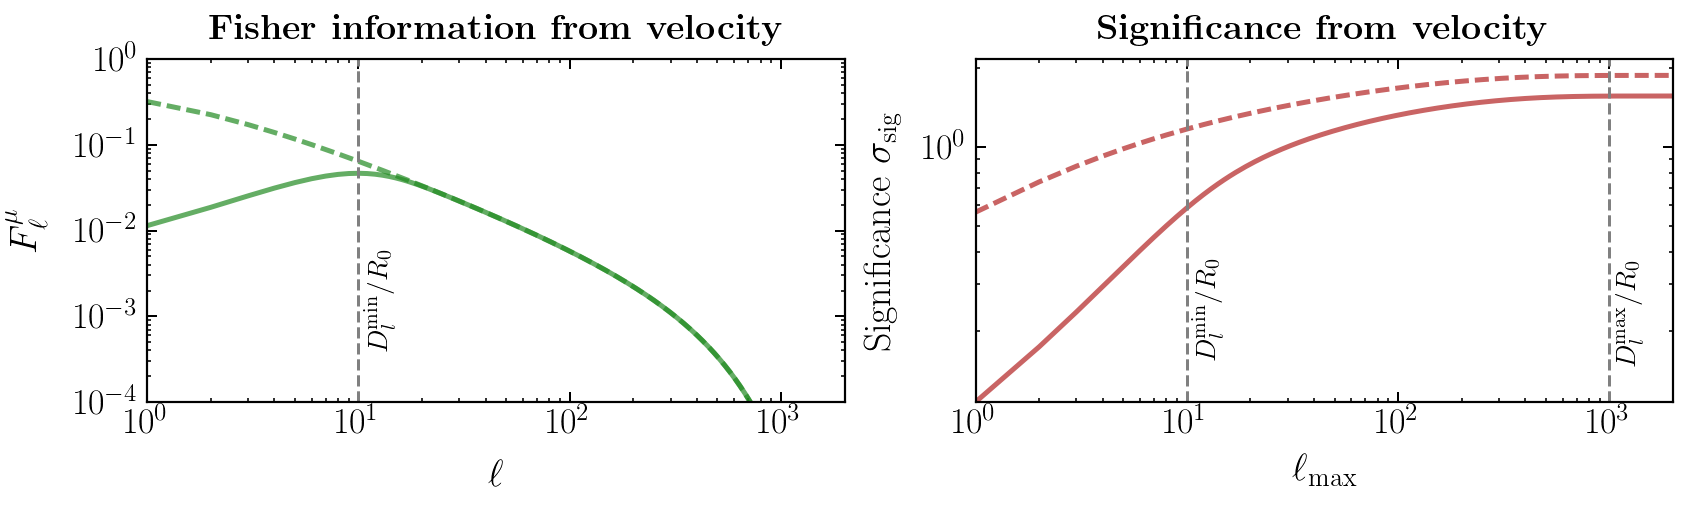

In [16]:
l_ary = np.arange(1,2000)

sigma_mu = 50
Dl_min = 0.1* kpc
Dl_max = 10 * kpc
R_0 = 10 * pc

print(np.sqrt(np.sum(F(1e8 * M_s, R_0,  1e-3, 1, l_ary, Dl_min, Dl_max, sigma_mu, 1e8))))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13/1.1,4/1.1))

ax1.plot(l_ary, F(1e8 * M_s, R_0,  1e-3, 1, l_ary, Dl_min, Dl_max, sigma_mu, 1e8), color='forestgreen')
ax1.plot(l_ary, F(1e8 * M_s, R_0,  1e-3, 1, l_ary, 1e-22*kpc, Dl_max, sigma_mu, 1e8), color='forestgreen',ls='--')
ax1.axvline(Dl_min / R_0, ls='--', color='grey', lw=1.5)
ax1.text(10** (np.log10(Dl_min / R_0) + .05 ), 3e-3, '$D_l^\mathrm{min}/R_0$',rotation=90, fontsize=14)

ax1.set_xlabel('$\ell$')
ax1.set_ylabel(r'$F_\ell^{\mu}$')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title(r"\textbf{Fisher information from velocity}")
ax1.set_xlim(min(l_ary), max(l_ary))
ax1.set_ylim(1e-4, 1)



ax2.plot(l_ary, np.sqrt(np.cumsum(F(1e8 * M_s, R_0,  1e-3, 1, l_ary, Dl_min, Dl_max, sigma_mu, 1e8))), color='firebrick')
ax2.plot(l_ary, np.sqrt(np.cumsum(F(1e8 * M_s, R_0,  1e-3, 1, l_ary, 1e-12*kpc, Dl_max, sigma_mu, 1e8))), color='firebrick',ls='--')

ax2.axvline(Dl_max / R_0, ls='--', color='grey', lw=1.5)
ax2.text(10** (np.log10(Dl_max / R_0) + .05 ), .3, '$D_l^\mathrm{max}/R_0$',rotation=90, fontsize=14)
ax2.axvline(Dl_min / R_0, ls='--', color='grey', lw=1.5)
ax2.text(10** (np.log10(Dl_min / R_0) + .05 ), .3, '$D_l^\mathrm{min}/R_0$',rotation=90, fontsize=14)

ax2.set_xlabel('$\ell_\mathrm{max}$')
ax2.set_ylabel('Significance $\sigma_\mathrm{sig}$')
ax2.set_xscale("log")
ax2.set_yscale("log")

ax2.set_title(r"\textbf{Significance from velocity}")
ax2.set_xlim(min(l_ary), max(l_ary))

plt.tight_layout()

# plt.savefig(plots_dir + "fisher_mu.pdf")

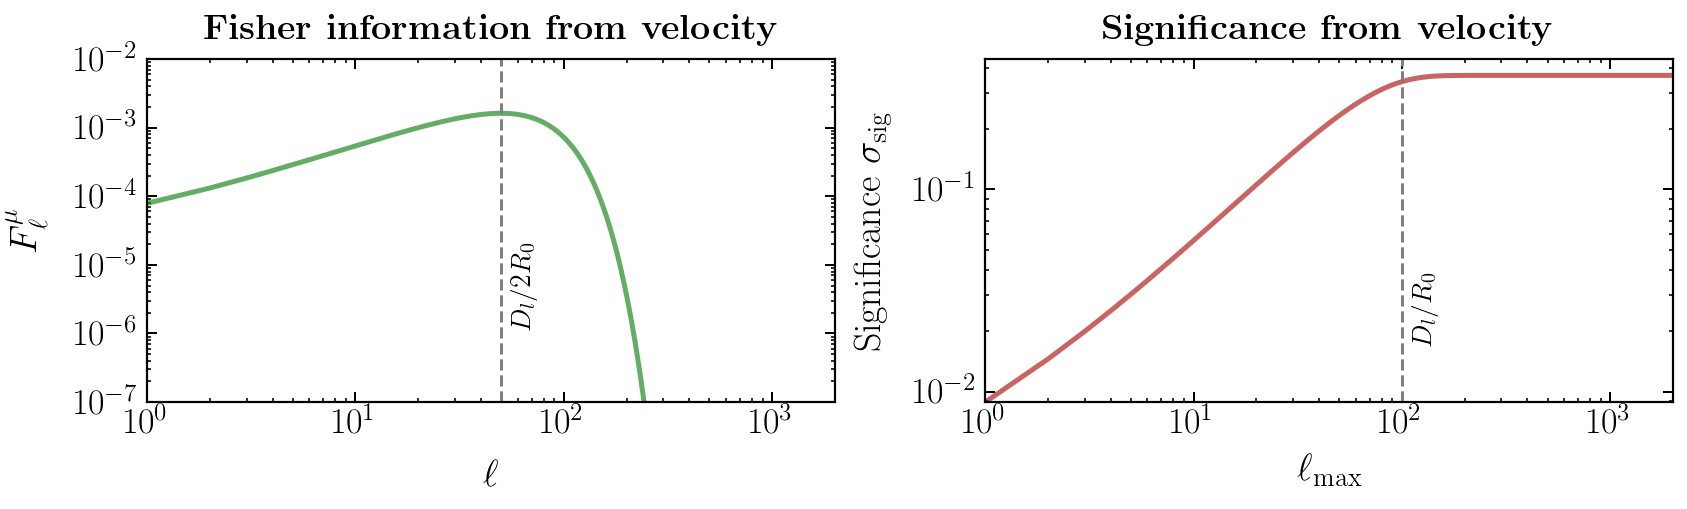

In [23]:
l_ary = np.arange(1,2000)

sigma_mu = 50
Dl = 1 * kpc
R_0 = 10 * pc

# print(np.sqrt(np.sum(F(1e8 * M_s, R_0,  1e-3, 1, l_ary, Dl_min, Dl_max, sigma_mu, 1e8))))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13/1.1,4/1.1))

ax1.plot(l_ary, F_single(1e8 * M_s, R_0,  1e-3, 1, l_ary, Dl, sigma_mu, 1e8), color='forestgreen')
ax1.axvline(0.5 * Dl / R_0, ls='--', color='grey', lw=1.5)
ax1.text(10** (np.log10(0.5 * Dl / R_0) + .05 ), 1e-5, '$D_l/2R_0$',rotation=90, fontsize=14)

ax1.set_xlabel('$\ell$')
ax1.set_ylabel(r'$F_\ell^{\mu}$')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title(r"\textbf{Fisher information from velocity}")
ax1.set_xlim(min(l_ary), max(l_ary))
ax1.set_ylim(1e-7,1e-2)

ax2.plot(l_ary, np.sqrt(np.cumsum(F_single(1e8 * M_s, R_0,  1e-3, 1, l_ary, Dl, sigma_mu, 1e8))), color='firebrick')
ax2.axvline(Dl / R_0, ls='--', color='grey', lw=1.5)
ax2.text(10** (np.log10(Dl / R_0) + .05 ), 3e-2, '$D_l/R_0$',rotation=90, fontsize=14)

ax2.set_xlabel('$\ell_\mathrm{max}$')
ax2.set_ylabel('Significance $\sigma_\mathrm{sig}$')
ax2.set_xscale("log")
ax2.set_yscale("log")

ax2.set_title(r"\textbf{Significance from velocity}")
ax2.set_xlim(min(l_ary), max(l_ary))

plt.tight_layout()

plt.savefig(plots_dir + "fisher_mu_single.pdf")

/Users/smsharma/.conda/envs/Lensing-PowerSpectra/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


(1.0, 1000.0)

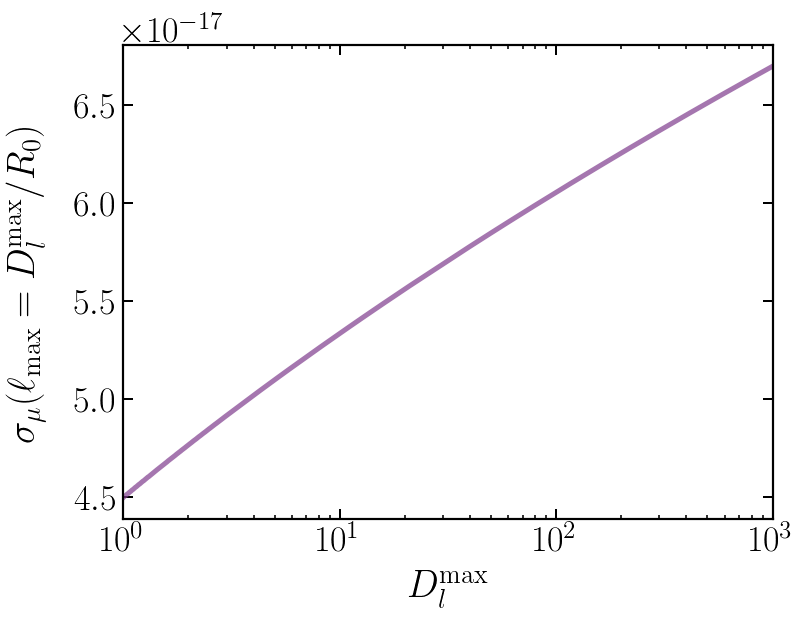

In [24]:
Dl_min = 1e-4 * kpc

Dl_max_ary = np.logspace(0,3,1000)*kpc
F_ary = []
for Dl_max in Dl_max_ary:
    l_ary = np.arange(1,Dl_max/R_0)
    F_ary.append(np.sqrt(np.sum(F_alpha(1e2 * M_s, R_0,  1e-3, 1, l_ary, Dl_min, Dl_max, sigma_mu, 1e8))))
    
plt.plot(Dl_max_ary/kpc, F_ary)
plt.xscale("log")

plt.xlabel(r"$D_l^\mathrm{max}$")
plt.ylabel(r"$\sigma_\mu(\ell_\mathrm{max}=D_l^\mathrm{max}/R_0$)")

plt.xlim(min(Dl_max_ary/kpc), max(Dl_max_ary/kpc))

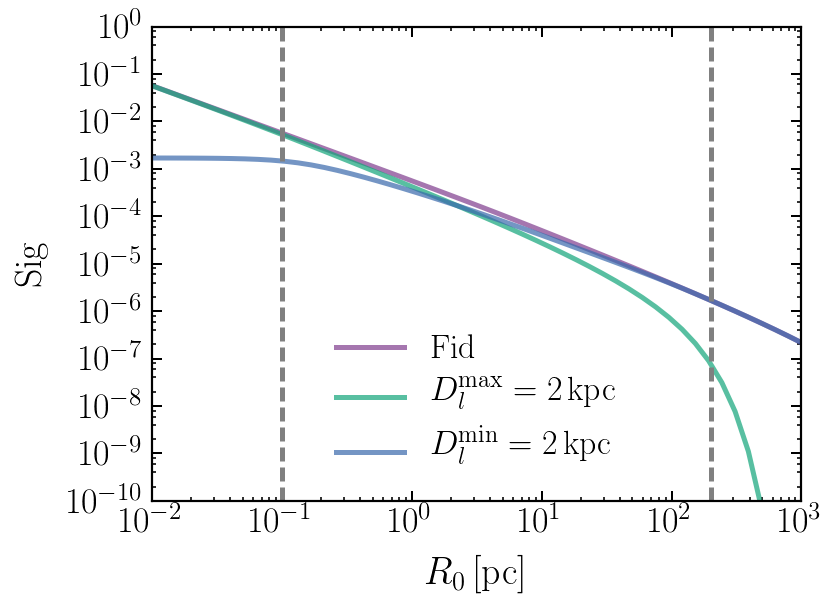

In [25]:
l_ary = np.arange(10,1e4)

R_0_ary = np.logspace(-2,3) * pc
F_R_0_1_ary = []
F_R_0_2_ary = []
F_R_0_3_ary = []

for R_0 in R_0_ary:
    F_R_0_1_ary.append(np.sqrt(np.sum(F(1e8 * M_s, R_0,  1e-3, 1, l_ary, 1e-12*kpc, 100*kpc, 10000, 1e8))))
    F_R_0_2_ary.append(np.sqrt(np.sum(F(1e8 * M_s, R_0,  1e-3, 1, l_ary, 1e-12*kpc, 2*kpc, 10000, 1e8))))
    F_R_0_3_ary.append(np.sqrt(np.sum(F(1e8 * M_s, R_0,  1e-3, 1, l_ary, 1*kpc, 100*kpc, 10000, 1e8))))

plt.figure()
plt.plot(R_0_ary/ pc, F_R_0_1_ary, label=r'Fid')
plt.plot(R_0_ary/ pc, F_R_0_2_ary, label=r'$D_l^\mathrm{max} = 2$\,kpc')
plt.plot(R_0_ary/ pc, F_R_0_3_ary, label=r'$D_l^\mathrm{min} = 2$\,kpc')

plt.axvline(1*kpc/np.max(l_ary)/pc, ls='--', color='grey')
# plt.axvline(5*kpc/np.min(l_ary)/pc, ls='--', color='grey')
plt.axvline(2*kpc/np.min(l_ary)/pc, ls='--', color='grey')

plt.xlabel('$R_0$\,[pc]')
plt.ylabel('Sig')
plt.xscale("log")
plt.yscale("log")

plt.xlim(min(R_0_ary/pc), max(R_0_ary/pc))
plt.ylim(1e-10,1)

plt.legend()

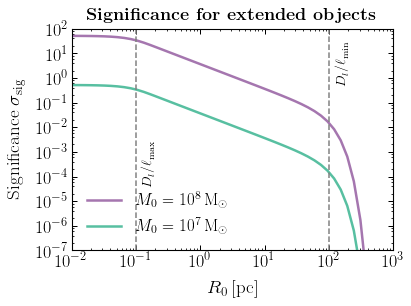

In [14]:
l_ary = np.arange(10,1e4)
Dl = 1*kpc
R_0_ary = np.logspace(-2,3) * pc
F_R_0_1_ary = []
F_R_0_2_ary = []
F_R_0_3_ary = []

for R_0 in R_0_ary:
    F_R_0_1_ary.append(np.sqrt(np.sum(F_single(1e8 * M_s, R_0,  1e-3, 1, l_ary, Dl, 50, 1e8))))
    F_R_0_2_ary.append(np.sqrt(np.sum(F_single(1e7 * M_s, R_0,  1e-3, 1, l_ary, Dl, 50, 1e8))))

plt.figure()
plt.plot(R_0_ary/ pc, F_R_0_1_ary, label=r'$M_0 = 10^8\,\mathrm{M}_\odot$')
plt.plot(R_0_ary/ pc, F_R_0_2_ary, label=r'$M_0 = 10^7\,\mathrm{M}_\odot$')

plt.axvline(Dl/np.max(l_ary)/pc, ls='--', color='grey', lw=1.5)
plt.axvline(Dl/np.min(l_ary)/pc, ls='--', color='grey', lw=1.5)
plt.text(10** (np.log10(Dl/np.max(l_ary)/pc) + .1 ), 1e-3, '$D_l/\ell_\mathrm{max}$',rotation=90, fontsize=14)
plt.text(10** (np.log10(Dl/np.min(l_ary)/pc) + .1 ), 10, '$D_l/\ell_\mathrm{min}$',rotation=90, fontsize=14)

plt.xlabel('$R_0$\,[pc]')
plt.ylabel('Significance $\sigma_\mathrm{sig}$')
plt.xscale("log")
plt.yscale("log")

plt.xlim(min(R_0_ary/pc), max(R_0_ary/pc))
plt.ylim(1e-7,100)

plt.legend()
plt.title((r"\textbf{Significance for extended objects}"))

plt.tight_layout()

plt.savefig(plots_dir + "sig_R0.pdf")